<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.3
# *KNN classification Lab*

**In this lab, we will:**
- Practice KNN classification on a dataset of breast cancer.
- Predict the `diagnoosis` of a patient from predictor variables of your choice.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [3]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [4]:
breast_cancer_csv = '../../data/breast-cancer-wisconsin-data.csv'

In [5]:
df = pd.read_csv(breast_cancer_csv, index_col='id')

In [6]:
df.drop(labels='Unnamed: 32', axis=1, inplace=True)

### 2. EDA 

Explore dataset. Clean data. Find correlation. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

<AxesSubplot:>

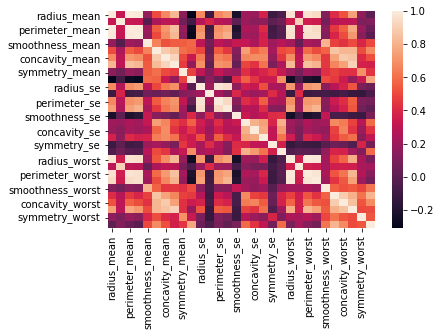

In [10]:
sns.heatmap(df.corr())

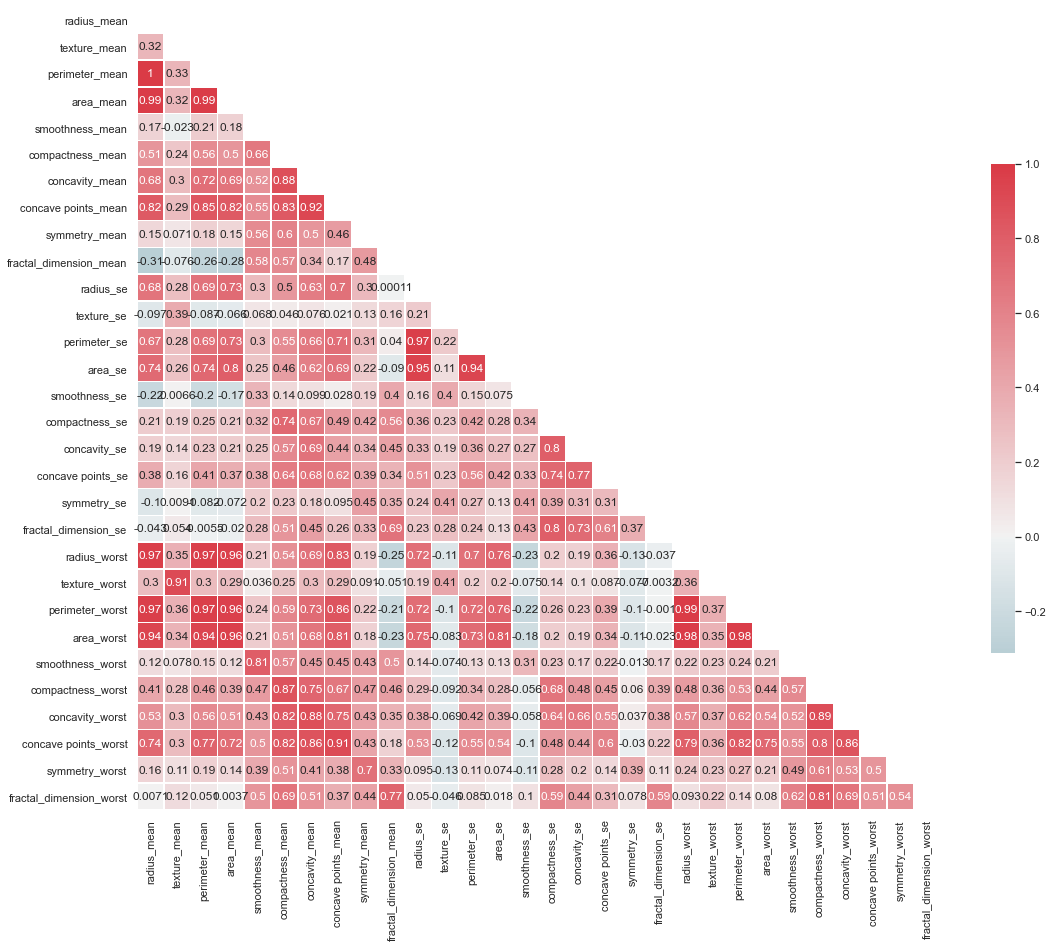

In [14]:
# Copied code from seaborn examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show();

In [11]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [12]:
df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### 3. Set up the `diagnosis` variable as your target. How many classes are there?

<AxesSubplot:>

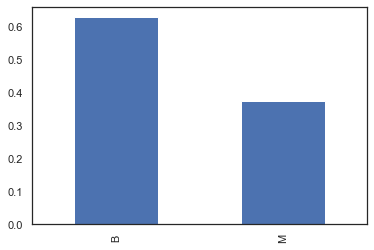

In [15]:
# ANSWER
df['diagnosis'].value_counts(normalize=True).plot(kind='bar')

In [16]:
df['diagnosis'].value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

In [17]:
target_column = 'diagnosis'

In [18]:
y = df[target_column]

In [19]:
y.unique()

array(['M', 'B'], dtype=object)

### 4. What is the baseline accuracy?

In [20]:
# ANSWER
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

### 5. Choose features to be your predictor variables and set up your X.

In [21]:
# ANSWER
feature_columns = [c for c in df.columns if c !='diagnosis']
X = df[feature_columns]

### 6. Fit a `KNeighborsClassifier` with 1 neighbor using the target and predictors.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
# ANSWER
# Make an instance of a KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# fit on the unstandardized data:
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

### 7. Evaluate the accuracy of your model.
- Is it better than baseline?
- Is it legitimate?

In [24]:
# ANSWER
# predict the response values for the observations in X ("test the model")
y_pred_class = knn.predict(X)
# store the predicted response values
from sklearn import metrics
print(metrics.accuracy_score(y, y_pred_class))

1.0


### 8. Create a 80-20 train-test-split of your target and predictors. Refit the KNN and assess the accuracy.

In [28]:
from sklearn.model_selection import train_test_split
# ANSWER
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9298245614035088


### 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data.

In [35]:
X_train.shape[0]

455

In [37]:
# ANSWER
# Create an instance of KNeighborsClassifier where n_neighbors = number of rows in the training data
knn = KNeighborsClassifier(n_neighbors=X_train.shape[0])

# Fit Train Data
knn.fit(X_train, y_train)
# Print accuracy_score
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.6228070175438597


### 10. Fit the KNN at values of K from 1 to the number of rows in the training data.
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

In [38]:
# ANSWER
# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, X_train.shape[0]+1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    test_acc.append(knn.score(X_test, y_test))

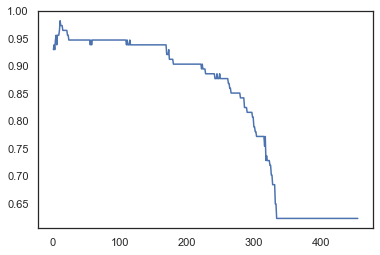

In [40]:
plt.plot(range(1, X_train.shape[0]+1), test_acc)

### 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds.


In [55]:
# ANSWER
from sklearn.model_selection import cross_val_score

folds = 5
max_neighbors = np.floor(X_train.shape[0])
print(max_neighbors)

test_acc = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc.append(cross_val_score(knn, X, y, cv=5).mean())

455.0


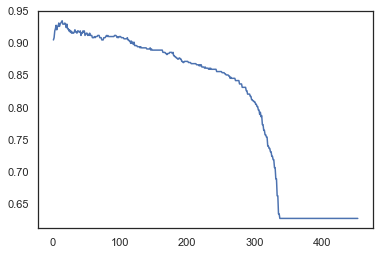

In [57]:
plt.plot(range(1, int(max_neighbors)), test_acc)

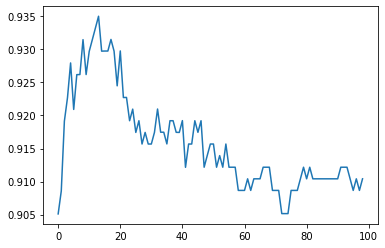

In [59]:
test_acc_std = []
for i in range(1, 25): 
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc_std.append(cross_val_score(knn, X, y, cv=5).mean())


plt.plot(test_acc_std)

### 12. Standardize the predictor matrix and cross-validate across the different K.
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [48]:
# ANSWER
# Standarize X
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X)

In [51]:
# ANSWER
# plot test accuracy by number of neighbors:
test_acc_std = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc_std.append(cross_val_score(knn, Xs, y, cv=5).mean())

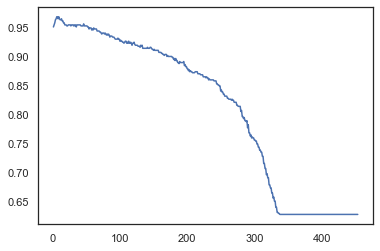

In [52]:
plt.plot(range(1, int(max_neighbors)), test_acc_std)

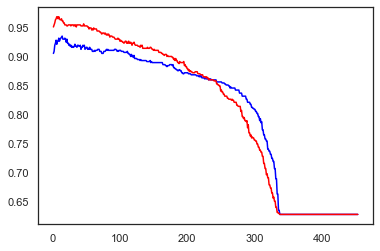

In [56]:
plt.plot(range(1, int(max_neighbors)), test_acc, color='blue')
plt.plot(range(1, int(max_neighbors)), test_acc_std, color='red')

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



